usando uma imagem de tamanho menor:
 407 x 540

Dataset maior 30k 

In [ ]:
#
#  ambiente..
#
# ref https://colab.research.google.com/drive/151805XTDg--dgHb3-AXJCpnWaqRhop_2#scrollTo=qvyB0VG4j4zx

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'


GPU 0: Tesla T4 (UUID: GPU-cdbff0dd-9489-4403-50f6-48733ea7b84b)
Mon Nov 16 02:29:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
#
# mount and unzip
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# initialize...
#
checkdir_pre= "v97exp/end2end--8lines--maior--redemaior--try10--/1007"
checkdir    = "v97exp/8lines-try13--finetune--/1012"

NO_TEACH= True
FREEZE_ENCODER= False
TRAIN_LENGTH= 16
BATCH_SIZE = 32
EMBEDDING_DIM = 256
UNITS = 512
LEARNING_RATE=0.0005
NUM_OF_WORDS= 220
SAMPLED= True
VOCAB_SIZE= NUM_OF_WORDS+1 
SAVE_IF_BETTER_THAN_LOSS= 0.0   #dont save
_best_loss= 10  # best loss until now


In [ ]:
#
# Ref=> https://www.tensorflow.org/tutorials/text/image_captioning
# https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2
#
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle
from google.colab import drive
from pathlib import Path
print(tf.__version__) 

Found GPU at: /device:GPU:0
2.3.0


In [ ]:
# 
# unzip
#
#!unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/final-5K.zip'
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/final-32K-8lines.zip'

In [ ]:
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/unified-all-labels-noponct.zip'

In [ ]:
#
# basics
#
tstart= time.time()
def print_time():
  end = time.time()
  hours, rem = divmod(end-tstart, 3600)
  minutes, seconds = divmod(rem, 60)
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print_time()

def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

00:00:00.00


In [ ]:
#
# tokenizer
#
def build_tokenizer():
  with open('/content/unified-all-labels-noponct.txt') as file:
    labels = [line.strip() for line in file]
  labels= ['<start> ' + label + ' <end>' for label in labels]

  # Choose the top 5000 words from the vocabulary
  print( 'building...')
  top_k = NUM_OF_WORDS   # para ajustar ao modelo antigo...
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                    oov_token="<unk>",
                                                    filters= ' ')
                                                    # filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

  #forca a usar sempre uma lista com todas as words com 1 ocorrecia de cada word
  tokenizer.fit_on_texts(labels)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  return tokenizer

# NEW tokenizer
tokenizer= build_tokenizer()
print( 'total do vocabularario= ', len(tokenizer.word_index))    # expected 1578
print( 'considerados no encoding= ', NUM_OF_WORDS)

building...
total do vocabularario=  1578
considerados no encoding=  220


In [ ]:
#
# load images and labels
#
def cleanup(line):
    return re.sub('[^0-9a-zA-Z -]+', '', line).replace( 'x', '')

def load_data_from( path):
	image_files= glob( os.path.join( path, 'images/*.jpg'))
	image_files.sort()

	label_files= glob( os.path.join( path, 'labels/*.pgn'))
	label_files.sort()
	labels= [read_label( f) for f in label_files]
	labels= [cleanup( x).lower() for x in labels]
	labels= ['<start> ' + label + ' <end>' for label in labels]

	# poderia ser menor... mas pega os primeiros 10. Nem precisava restringir...
	labels= [label.split()[0:32] for label in labels]

	# somente uma parte por enquanto
	if SAMPLED:
		n= int( len( image_files)*0.5); 
		image_files= image_files[0:n]
		labels= labels[0:n]
		print( "sample size= ", n)

	label_indexes = tokenizer.texts_to_sequences(labels)
	for i in range( 0, 3):
		print( labels[i], '=>', label_indexes[i])
 
	return image_files, label_indexes, labels

train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/final-32K-8lines/train')
valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/final-32K-8lines/valid')

sample size=  11386
['<start>', 'nc3', 'd5', 'e4', 'c6', 'f4', 'g6', 'nf3', 'bg7', 'e5', 'h5', 'd4', 'nh6', 'be3', 'bg4', 'h3', 'nf5', '<end>'] => [5, 8, 11, 9, 53, 21, 20, 4, 29, 13, 41, 7, 1, 24, 89, 40, 106, 6]
['<start>', 'nc3', 'd5', 'e4', 'd4', 'nce2', 'e5', 'ng3', 'nf6', 'nf3', 'nc6', 'bc4', 'be7', 'o-o', 'o-o', 'd3', 'h6', '<end>'] => [5, 8, 11, 9, 7, 1, 13, 165, 3, 4, 10, 30, 23, 2, 2, 114, 38, 6]
['<start>', 'nc3', 'd5', 'e4', 'e6', 'nf3', 'nf6', 'd3', 'be7', 'be2', 'c5', 'o-o', 'nc6', 're1', 'd4', 'nb1', 'e5', '<end>'] => [5, 8, 11, 9, 15, 4, 3, 114, 23, 45, 12, 2, 10, 37, 7, 1, 13, 6]
sample size=  3027
['<start>', 'nc3', 'd5', 'e4', 'd4', 'nce2', 'e5', 'ng3', 'nf6', 'bc4', 'nc6', 'nf3', 'bd6', 'd3', 'h6', 'a3', 'qe7', '<end>'] => [5, 8, 11, 9, 7, 1, 13, 165, 3, 30, 10, 4, 71, 114, 38, 58, 68, 6]
['<start>', 'nf3', 'nc6', 'd4', 'd5', 'bf4', 'bg4', 'e3', 'e6', 'h3', 'bh5', 'c4', 'bb4', 'nc3', 'nge7', 'rc1', 'o-o', '<end>'] => [5, 4, 10, 7, 11, 67, 89, 77, 15, 40, 1, 14, 98, 

In [ ]:
#
# PREPROCESSAMENTO...
#

In [ ]:
#
# carrega VGG19
#
image_model = tf.keras.applications.VGG19(include_top=False,
                                                weights='imagenet',
                                                input_shape= (575, 677, 3))  # => gera (16, 19, 2048)
                                                # input_shape= (900, 678, 3))  # => gera (16, 19, 2048)
                                                # O input shape nao é obrigatorio, mas setando dá para
                                                # ver o tamanho do output
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
print( image_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 575, 677, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 575, 677, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 575, 677, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 287, 338, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 287, 338, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 287, 338, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 143, 169, 128)     0     

In [ ]:
# -1 gera (None, 18, 21, 512)
ATTENTION_SHAPE= (17, 21) #(28,21)
FEATURES_SHAPE = 512
ATTENTION_FEATURES_SHAPE = ATTENTION_SHAPE[0]*ATTENTION_SHAPE[1]  #16*19   # 308


In [ ]:
#
# build cache por preprocessed images
#
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (575, 677)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.image.resize(img, (540, 407)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path
	
def build_cache_for( img_name_vector):
  encode_train = sorted(set(img_name_vector))

  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8) #(16)

  for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
	  
	  
build_cache_for( train_img_names)
build_cache_for( valid_img_names)

In [ ]:
#
# build dataset
#

In [ ]:
# Load the numpy files
BUFFER_SIZE = 1000
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
  

def build_dataset( img_names, label_indexes):
  # deixa no mesmo tamanho, maximo 32
  label_indexes= [label[:32] for label in label_indexes]
  label_indexes= tf.keras.preprocessing.sequence.pad_sequences(label_indexes, padding='post')

  dataset = tf.data.Dataset.from_tensor_slices((img_names, label_indexes))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE, seed= 0).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

  
train_dataset= build_dataset( train_img_names, train_label_indexes)
valid_dataset= build_dataset( valid_img_names, valid_label_indexes)

train_num_steps= len( train_img_names)//BATCH_SIZE
valid_num_steps= len( valid_img_names)//BATCH_SIZE

In [ ]:
#
# Model
#

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # print( 'BahdanauAttention.features =>', features.shape) #(64, 64, 256), segundo 64=length(encoder_output)
    # print( 'BahdanauAttention.hidden =>', hidden.shape) #(64, 512)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # print( 'BahdanauAttention.hidden_with_time_axis =>', hidden_with_time_axis.shape) #(64, 1, 512)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
    # print( 'BahdanauAttention.score =>', score.shape)   #(64, 64, 512)

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # print( 'BahdanauAttention.attention_weights =>', attention_weights.shape)  #(64, 64, 1) segundo 64 vem do tamanho da sequencia apos cnn

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape)  #(64, 64, 256) segundo 64= length(encoder_output)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape) #(64, 256)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):

    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim, units):
        super(CNN_Encoder, self).__init__()
        self.units = units
        # shape after fc == (batch_size, 64, embedding_dim)
        # self.gru1= tf.keras.layers.GRU(self.units,
                                  #      dropout= ENCODER_DROPOUT,
                                  #  return_sequences=True) 
        self.bgru= tf.keras.layers.Bidirectional( tf.keras.layers.GRU(self.units,
                                       dropout= 0.5,
                                   return_sequences=True)) 
        self.drop= tf.keras.layers.Dropout( 0.5)
        # self.gru= tf.keras.layers.GRU(self.units,
        #                            return_sequences=True)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.bgru( x)
        # x = self.bgru2( x)
        x = self.drop(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU( self.units,
                                   dropout= 0.5,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # self.gru.trainable= False
    # self.fc1 = tf.keras.layers.Dense(self.units, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    #512
    # self.fc2 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    #256
    self.fcF = tf.keras.layers.Dense(vocab_size, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    # 120

    # self.bn0 = tf.keras.layers.BatchNormalization()
    # self.bn1 = tf.keras.layers.BatchNormalization()
    # self.bn2 = tf.keras.layers.BatchNormalization()

    # self.drop0= tf.keras.layers.Dropout( 0.7)
    # self.drop1= tf.keras.layers.Dropout( 0.7)
    # self.drop2= tf.keras.layers.Dropout( 0.7)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
                        center=True, scale=True, beta_initializer='zeros', 
                        gamma_initializer='ones', moving_mean_initializer='zeros', 
                        moving_variance_initializer='ones', beta_regularizer=None, 
                        gamma_regularizer=None, beta_constraint=None, 
                        gamma_constraint=None)

    self.attention = BahdanauAttention(self.units)
    if FREEZE_ENCODER:
      self.attention.trainable = False

  def freeze_attention(self):
      self.attention.trainable = False

  def call(self, x, features, hidden):
    # print( 'decoder.call=> ', x.shape, features.shape, hidden.shape) #(64, 1) (64, 64, 256) (64, 512)

    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    # print( 'decoder.attention=> ', context_vector.shape, attention_weights.shape) #(64, 256) (64, 64, 1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # print( 'decoder.embedding=> ', x.shape) #(64, 1, 256)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # print( 'decoder.concat=> ', x.shape) #(64, 1, 512)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output = self.bn0(output)
    # output = self.drop0(output)

    # x = self.fc1(output)    #fc1= Dense( 512)
    x= output
    # x = self.bn1(x)
    # x = self.drop1(x)

    x = tf.reshape(x, (-1, x.shape[2])) 
    # x = self.fc2(x) # 256
    # x = self.bn2(x)
    # x = self.drop2(x)

    x= self.dropout(x)
    x= self.batchnormalization(x)
    x = self.fcF(x) #fc2= Dense(5000)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# 
# build the model
#

In [ ]:
encoder = CNN_Encoder(EMBEDDING_DIM, UNITS)
if FREEZE_ENCODER:
  encoder.trainable = False

decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # print( 'loss_function.real, pred', real.shape, pred.shape)  #(64,) (64, 5001)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
#
# checkpoint manager
#

In [ ]:
def build_and_recover_checkpoint( checkdir_pre, checkdir):
  ckpt = tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer = optimizer)
                              
  checkpoint_path = "/content/drive/My Drive/mestrado/"+checkdir+"/checkpoints/train"
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

  epoch = 0
  if ckpt_manager.latest_checkpoint:
    print( "restoring from current "+ ckpt_manager.latest_checkpoint)
    epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print( '_epoch= ', epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
  elif not checkdir_pre is None:
    checkpoint_pre_path = "/content/drive/My Drive/mestrado/"+checkdir_pre+"/checkpoints/train"
    lastest_pre= tf.train.latest_checkpoint(checkpoint_pre_path)
    if lastest_pre:
      print( "restore from pretraining  "+ lastest_pre, '...')
      ckpt.restore( tf.train.latest_checkpoint(checkpoint_pre_path))
  else:
      pass
  return ckpt_manager, ckpt, epoch

def restore_checkpoint_to_last():
  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print( 'restored!', ckpt_manager.latest_checkpoint)
  else:
    print( 'no checkpoint found!!')

ckpt_manager, ckpt, _epoch= build_and_recover_checkpoint( checkdir_pre, checkdir)

restore from pretraining  /content/drive/My Drive/mestrado/v97exp/end2end--8lines--maior--redemaior--try10--/1007/checkpoints/train/ckpt-14 ...


In [ ]:
#
# training
#

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

def reset_metric_plot():
  global loss_plot_train, loss_plot_valid, acc_plot_train, acc_plot_valid
  loss_plot_train = []
  loss_plot_valid = []
  acc_plot_train = []
  acc_plot_valid = []
reset_metric_plot()

def plot_metrics():
  plt.plot(loss_plot_train)
  plt.plot(loss_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.gca().legend(('train loss','validation loss'))
  plt.show()

  plt.plot(acc_plot_train)
  plt.plot(acc_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.title('Acc Plot')
  plt.gca().legend(('train acc','validation acc'))
  plt.show()  

In [ ]:
@tf.function
def train_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, train_length): 
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      # tf.keras.backend.print_tensor( predictions)
      # tf.keras.backend.print_tensor( tf.reduce_max( predictions))
      # tf.keras.backend.print_tensor( tf.reduce_min( predictions))

      loss += loss_function(target[:, i], predictions)
      train_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))

  # update model
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def call_train_step_for_debug():
  batch, (img_tensor, target)= next( enumerate(train_dataset))
  batch_loss, t_loss = train_step(img_tensor[0:1], target[0:1], 4)
  print( 'loss= ', batch_loss.numpy())

# call_train_step_for_debug()

In [ ]:
#
# call train without update the gradient
#
@tf.function
def test_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)
  features = encoder(img_tensor)

  for i in range(1, train_length):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      valid_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))
  return loss, total_loss


In [ ]:
def train_more( loss_target, train_length, val_loss_limit): #, n_epoch):
  global _epoch
  global _best_loss

  MAX_EPOCH=200 

  print( "-- loss_target=>", loss_target, " train_length=", train_length)
  for _ in range(0,MAX_EPOCH):
      _epoch+= 1
      start = time.time()
      total_loss = 0
      
      train_acc_metric.reset_states()
      valid_acc_metric.reset_states()

      #
      # training loop
      #
      for (batch, (img_tensor, target)) in enumerate(train_dataset):
          batch_loss, t_loss = train_step(img_tensor, target, train_length)
          total_loss += t_loss

          if batch % 50 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                _epoch, batch, batch_loss.numpy() / train_length))

      train_loss= total_loss/train_num_steps
      loss_plot_train.append(train_loss)
      train_acc = float(train_acc_metric.result())
      acc_plot_train.append(train_acc)

      #
      # validation loop
      #
      valid_total_loss = 0
      for (batch, (img_tensor, target)) in enumerate(valid_dataset):
          batch_loss, t_loss = test_step(img_tensor, target, train_length)
          valid_total_loss += t_loss
      valid_loss= valid_total_loss / valid_num_steps
      loss_plot_valid.append(valid_loss)
      valid_acc = float(valid_acc_metric.result())
      acc_plot_valid.append(valid_acc)

      #
      # print..
      #

      print ('Epoch {} Loss {:.6f}  acc: {:.4f} [ Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                                  _epoch,
                                  train_loss, 
                                  train_acc,
                                  valid_loss, 
                                  valid_acc))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

      # 
      # target reached?
      #
      if loss_target> 0 and (train_loss)<= loss_target:
        print( "Target reached! stop!", ' len= ', train_length)

        ckpt_manager.save()  
        print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)
        plot_metrics()
        return True

      if train_loss< _best_loss:
        _best_loss= train_loss
        print( 'New record! _best_loss= ', _best_loss)
        if train_loss< SAVE_IF_BETTER_THAN_LOSS :
            ckpt_manager.save()  
            print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)

      # se validacao estoura significa que esta desaprendendo attention, portanto faz abort
      # TODO: Como implementar early stop?
      if valid_loss>= val_loss_limit:   
        print( "Oops, desaprendendo. Aborta sem salvar!")
        return False

  print( 'epoch exceeded')
  return False
    

In [ ]:
MAX_RETRY= 0
def train_more_with_retry( loss_target, _length, valid_loss_limit):
  retry_count= 0
  while True:
    print( 'len=', _length, ' try_count=', retry_count)
    ok= train_more( loss_target, _length, valid_loss_limit)
    if ok: 
      return True

    if retry_count>= MAX_RETRY:
      print( 'givup!')
      return False
    retry_count+= 1

    #volta para inicio da iteracao anterior
    restore_checkpoint_to_last()
  return False


In [ ]:
#
# Evaluation...
#
def evaluate(image, train_length):
  attention_plot = np.zeros((32, ATTENTION_FEATURES_SHAPE))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)

  dec_input = tf.expand_dims([0 if NO_TEACH else tokenizer.word_index['<start>']], 0)
  result = []

  for i in range(train_length): #<==
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    dec_input = tf.expand_dims([0 if NO_TEACH else predicted_id], 0)

  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot
    

In [ ]:
def plot_attention(image, result, attention_plot, expected= None):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(50, 50))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], ATTENTION_SHAPE) 
    ax = fig.add_subplot(8, 9, l+1)
    if expected is None or l>= len( expected):
      ax.set_title(result[l], fontsize= 40)
    else:
      ax.set_title(result[l]+" ("+expected[l]+")", fontsize= 40)
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()


In [ ]:
def evaluate_random_from_dataset( image_path, label_words, train_length):
  result, attention_plot = evaluate(image_path, train_length)

  # TODO: Pode estar errado...
  m = tf.keras.metrics.Accuracy()
  m.update_state( 
          [tokenizer.word_index[w] for w in label_words][1:train_length+1], 
          [tokenizer.word_index[w] for w in result][0:train_length])

  # print( 'accurary', float( m.result()))
  print ('expected=', label_words[1:])
  print ('predicted=', result)
  plot_attention(image_path, result, attention_plot, label_words[1:])

def evaluate_train( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( train_img_names[i], train_label_words[i], train_length) 

def evaluate_valid( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( valid_img_names[i], valid_label_words[i], train_length) 

#evaluate_train(1, 32)

In [ ]:
def evaluate_full_valid_dataset(_length):
    total_loss = 0
    valid_acc_metric.reset_states()
    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        batch_loss, t_loss = test_step(img_tensor, target, _length)
        total_loss += t_loss

    valid_loss= total_loss / valid_num_steps
    valid_acc = float(valid_acc_metric.result())
    print ('len {} Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                        _length,
                        valid_loss, 
                        valid_acc))


In [ ]:
#
# training loop, attention
#

iniciando para lengh 15  target 0.1
len= 15  try_count= 0
-- loss_target=> 0.1  train_length= 15
Epoch 1 Batch 0 Loss 7.4263
Epoch 1 Batch 50 Loss 3.0815
Epoch 1 Batch 100 Loss 2.2934
Epoch 1 Batch 150 Loss 1.6469
Epoch 1 Batch 200 Loss 1.6833
Epoch 1 Batch 250 Loss 1.3057
Epoch 1 Batch 300 Loss 0.8933
Epoch 1 Batch 350 Loss 0.8464
Epoch 1 Loss 1.976627  acc: 0.5266 [ Validation Loss 1.370363 valid_acc: 0.6578 ]
Time taken for 1 epoch 381.5308701992035 sec

New record! _best_loss=  tf.Tensor(1.9766275, shape=(), dtype=float32)
Epoch 2 Batch 0 Loss 2.7474
Epoch 2 Batch 50 Loss 2.1542
Epoch 2 Batch 100 Loss 1.1085
Epoch 2 Batch 150 Loss 0.7569
Epoch 2 Batch 200 Loss 0.5612
Epoch 2 Batch 250 Loss 0.5583
Epoch 2 Batch 300 Loss 0.5878
Epoch 2 Batch 350 Loss 0.4893
Epoch 2 Loss 1.002939  acc: 0.7236 [ Validation Loss 0.857538 valid_acc: 0.7647 ]
Time taken for 1 epoch 349.44779562950134 sec

New record! _best_loss=  tf.Tensor(1.0029386, shape=(), dtype=float32)
Epoch 3 Batch 0 Loss 2.0229
Ep

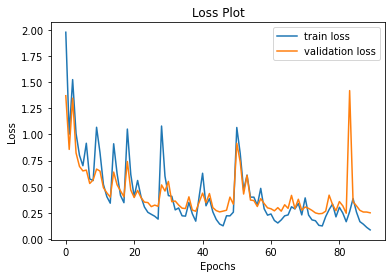

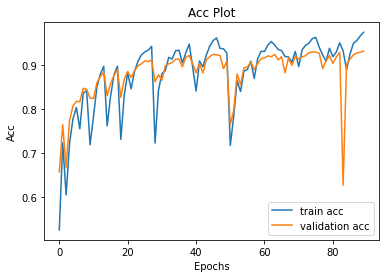

09:12:45.43
expected= ['nc3', 'd5', 'e4', 'c6', 'f4', 'g6', 'nf3', 'bg7', 'e5', 'h5', 'd4', 'nh6', 'be3', 'bg4', 'h3', 'nf5', '<end>']
predicted= ['nc3', 'd5', 'c4', 'e6', 'f4', 'g6', 'nf3', 'bg7', 'c5', 'h5', 'd4', 'nd6', 'be3', 'bg4', 'f3']


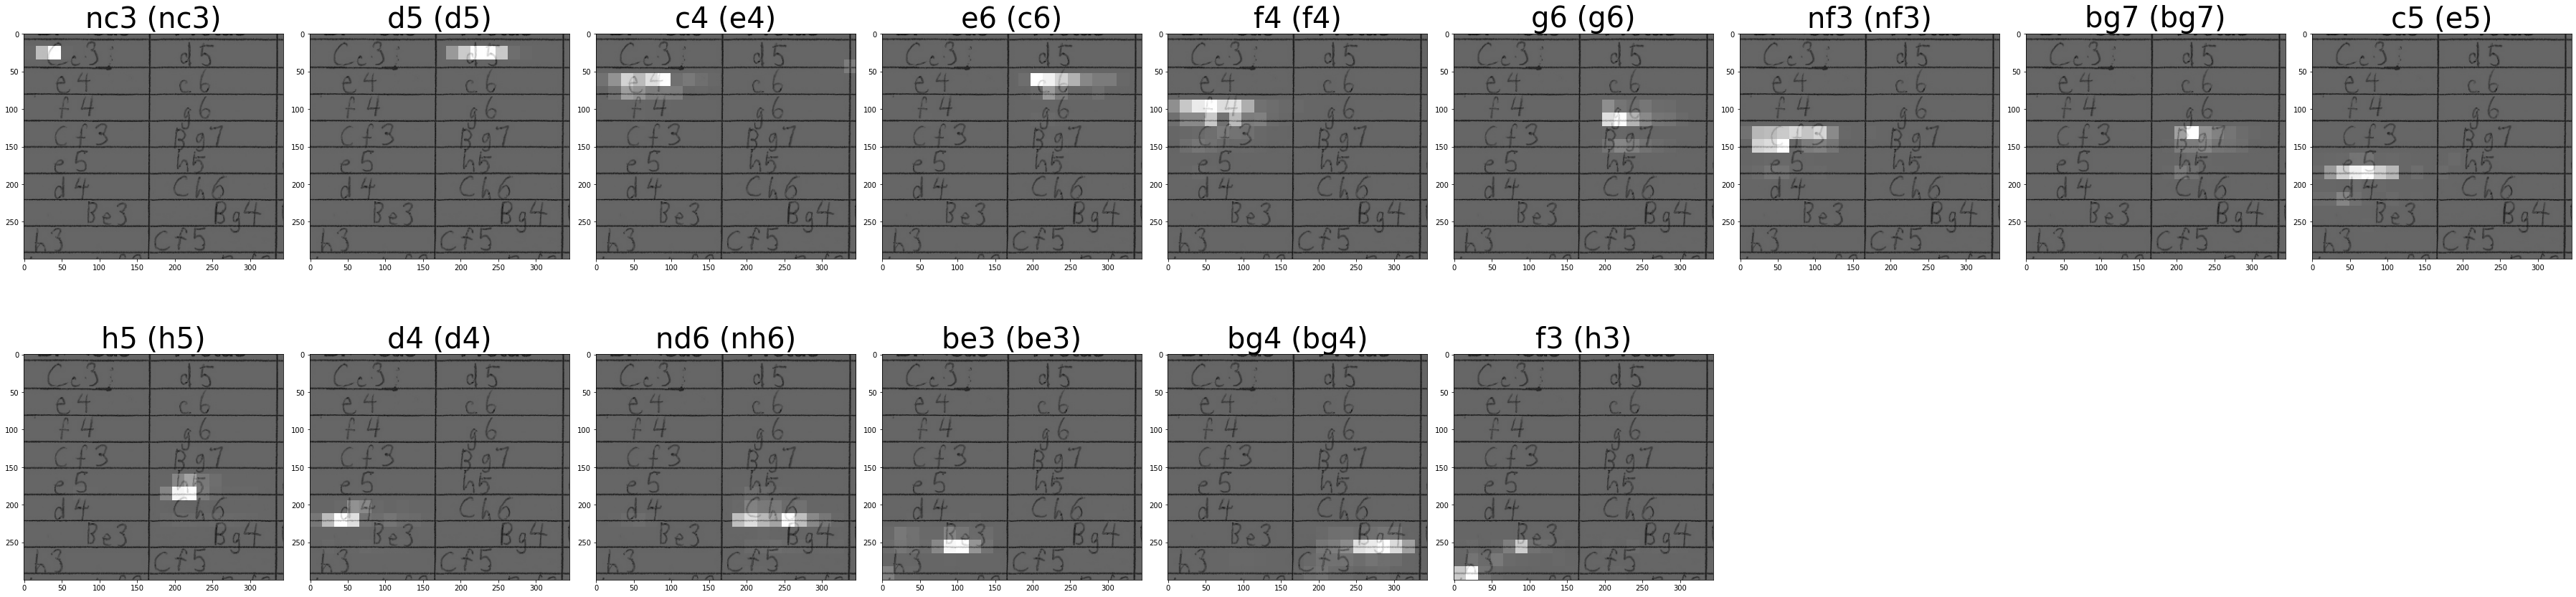

expected= ['nc3', 'd5', 'e4', 'd4', 'nce2', 'e5', 'ng3', 'nf6', 'bc4', 'nc6', 'nf3', 'bd6', 'd3', 'h6', 'a3', 'qe7', '<end>']
predicted= ['nc3', 'd5', 'e4', 'd4', 'nc3', 'e5', '<unk>', 'nf6', 'd4', 'nd6', 'nf3', 'bc6', 'f3', 'b6', 'd3']


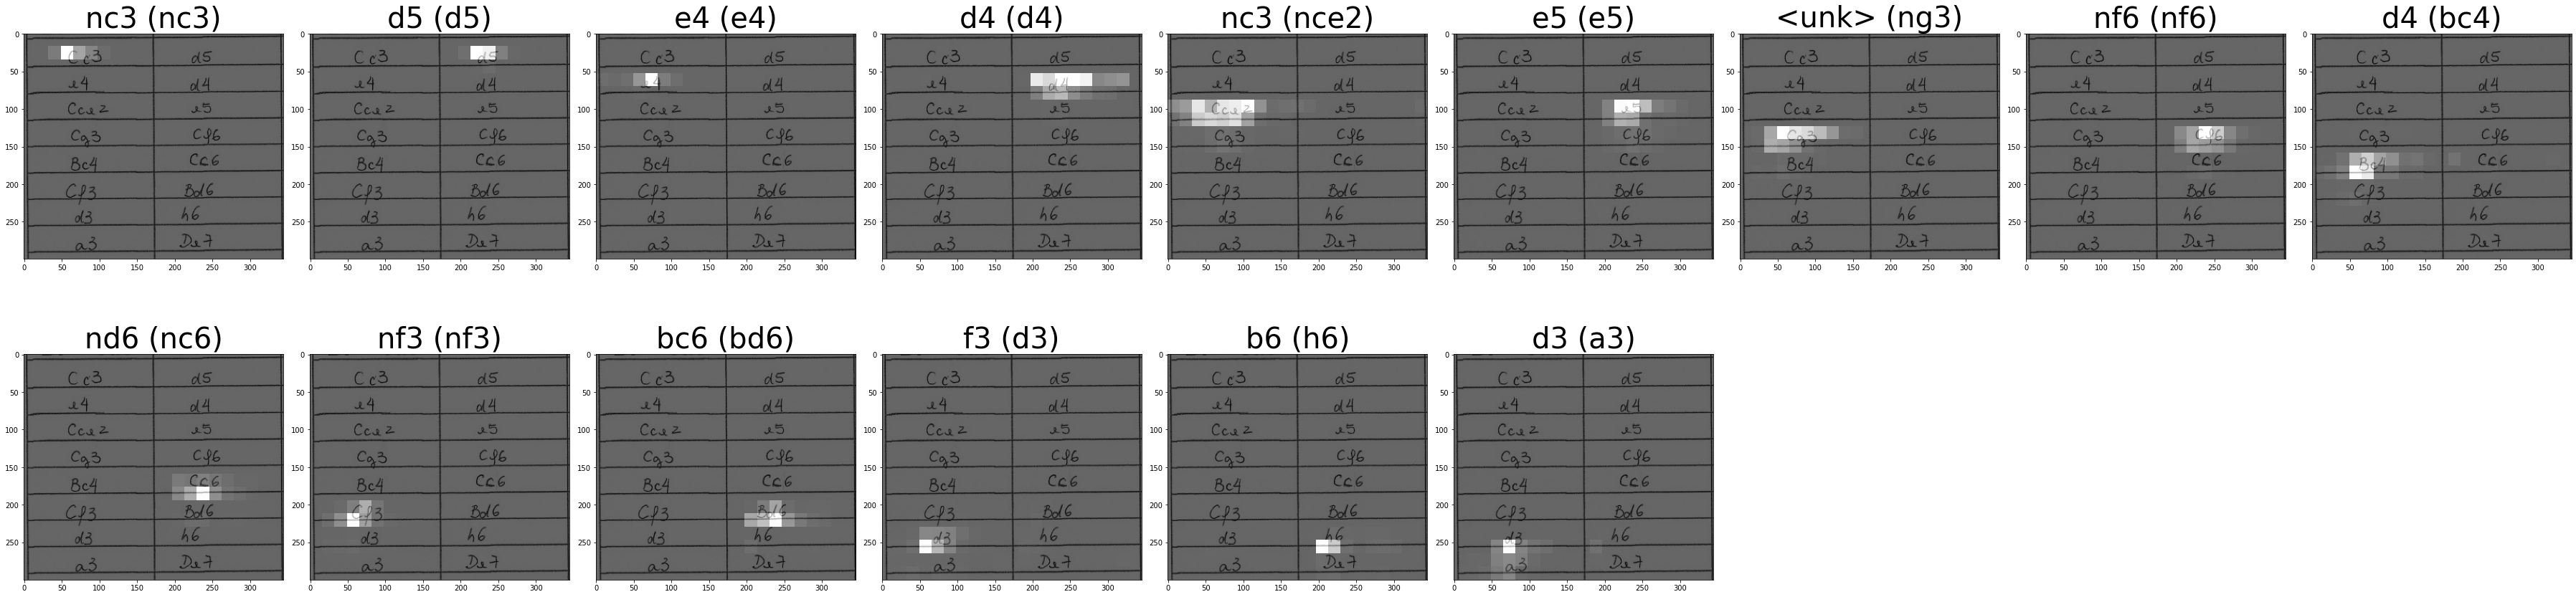

In [ ]:
for _len in [15]:
  for _target in [0.1]:
    print( 'iniciando para lengh', _len, ' target', _target)
    if not train_more_with_retry( _target, _len, 2000):
      print( 'numero de tentativas excedido sem sucesso. Abort')
      assert False

    print_time()    
    try:
      evaluate_train(1, _len)
      evaluate_valid(1, _len)
    except Exception as e:
      print( 'oops error..', e)


    # try:
    #   print( 'validando para tamanhos de sequencia diferentes..')    
    #   for eval_len in [4]:
    #     evaluate_full_valid_dataset( eval_len)
    # except Exception as e:
    #   print( 'oops error..', e)
